# Phase Unwrapping Simulations

This code compares different methods of phase unwrapping and how they handle noise, discontinuities and different type of data. The following methods are adressed:

1. Sorting by reliability following a noncontinuous path 

The algorithm sorts pixels by how reliable they are and then solves a path integral

Miguel Arevallilo Herráez, David R. Burton, Michael J. Lalor, and Munther A. Gdeisat, "Fast two-dimensional phase-unwrapping algorithm based on sorting by reliability following a noncontinuous path," Appl. Opt. 41, 7437-7444 (2002)

2. Perform 2D phase unwrapping using the weighted least-squares method 
described by Ghiglia and Romero (1994), using DCT-based Poisson solvers. If weighted uses picard iteration

   Ghiglia, D. C., & Romero, L. A. (1994). 
    "Robust two-dimensional weighted and unweighted phase unwrapping that uses 
    fast transforms and iterative methods." JOSA A, 11(1), 107–117.
    https://doi.org/10.1364/JOSAA.11.000107

    https://github.com/Zeekk9/GhiliaUnwap?tab=readme-ov-file

For the weighted option, I used the algorithm from before (sorting by reliability), and added a mask and smoothing of the weights in the borders

3.Network Programming based -  Phase differences of neighboring pixels can be estimated with a potential error that is an integer multiple
of 2pi. This suggests the formulation of the phase unwrapping problem as a global minimization problem with integer variables. The phase
unwrapping problem can be equated to the problem of finding the minimum cost flow on a network.

M. Costantini, "A novel phase unwrapping method based on network programming," in IEEE Transactions on Geoscience and Remote Sensing, vol. 36, no. 3, pp. 813-821, May 1998, doi: 10.1109/36.673674.
https://ieeexplore-ieee-org.tudelft.idm.oclc.org/document/673674

4. Arm based on this paper:

https://www-spiedigitallibrary-org.tudelft.idm.oclc.org/journals/optical-engineering/volume-57/issue-04/043113/Comparison-of-multihardware-parallel-implementations-for-a-phase-unwrapping-algorithm/10.1117/1.OE.57.4.043113.full

Works also on LS but adds mechanism to minimize impact of residues
with this source:

https://codeocean.com/capsule/2672585/tree/v1

* insert credits
* explenation on implemetation of C code

Still need to insrt some weights based on the paper, to improve results

5. Parallel Goldstein 
https://www.sciencedirect.com/science/article/pii/S0143816619306566?via%3Dihub




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import math
import sys, os
import time
import ctypes

sys.path.append(os.path.abspath("..")) 
from src.simulating_shapes.cylinder_phase import cylinder_phase_perp_to_z_3d
from src.phase_unwrapping_methods.Ghilia.Ghilia import unwrap_phase_weighted
from src.phase_unwrapping_methods.Ghilia.reliability import reliability_weight_map
from src.helpers.noise import additive_noise
from skimage.restoration import unwrap_phase
from sklearn.metrics import root_mean_squared_error
from src.helpers.rmse import evaluate_phase

# Fix dtype compatibility (needed for Kamui)

if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int_"): np.int_ = np.int64
if not hasattr(np, "bool_"): np.bool_ = bool

from kamui import unwrap_dimensional 
from scipy.fftpack import dctn, idctn

# -------------------------------------------------------------------
# Load the OpenMP .so you compiled
# -------------------------------------------------------------------
os.environ["OMP_NUM_THREADS"] = "32"  # Adjust based on your CPU
lib = ctypes.cdll.LoadLibrary("../src/phase_unwrapping_methods/ARM_parallel/code/libarm_openmp.so")

# Define the signature of unwrap_phase_ARM
lib.unwrap_phase_ARM.argtypes = [
    ctypes.POINTER(ctypes.c_double),  # wrapped
    ctypes.POINTER(ctypes.c_double),  # unwrapped
    ctypes.POINTER(ctypes.c_double),  # mask
    ctypes.POINTER(ctypes.c_double),  # iW
    ctypes.POINTER(ctypes.c_double),  # jW
    ctypes.c_int, ctypes.c_int,       # rows, cols
    ctypes.c_double, ctypes.c_double, # mu, lambda
    ctypes.c_int, ctypes.c_int        # numIter, ban_OmegaInit
]
lib.unwrap_phase_ARM.restype = None

# -------------------------------------------------------------------
# ARM unwrap helper
# -------------------------------------------------------------------
def arm_unwrap(arr, mu=1.0, lam=0.01, iters=100000,omega_init=1):
    H, W = arr.shape
    arr = np.ascontiguousarray(arr, dtype=np.float64)

    mask = np.ones_like(arr, dtype=np.float64)
    iW   = np.ones_like(arr, dtype=np.float64)
    jW   = np.ones_like(arr, dtype=np.float64)
    out  = np.zeros_like(arr, dtype=np.float64)

    lib.unwrap_phase_ARM(
        arr.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        out.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        mask.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        iW.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        jW.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        H, W,
        mu, lam, iters, omega_init
    )
    return out

# Optics
lam   = 0.532     # wavelength (µm)

Unwrarpping a simple ramp, with different noise levels

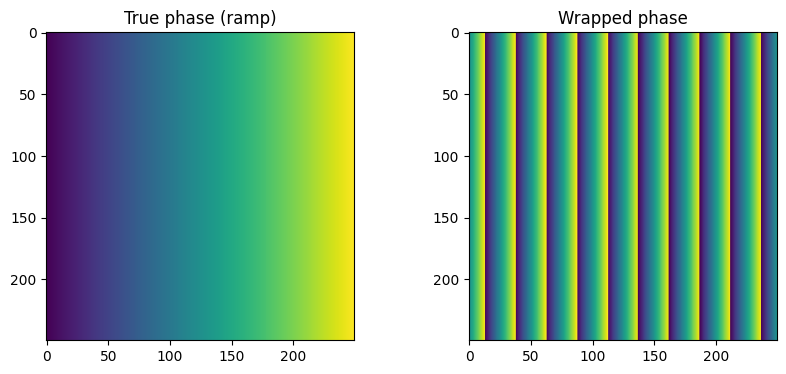

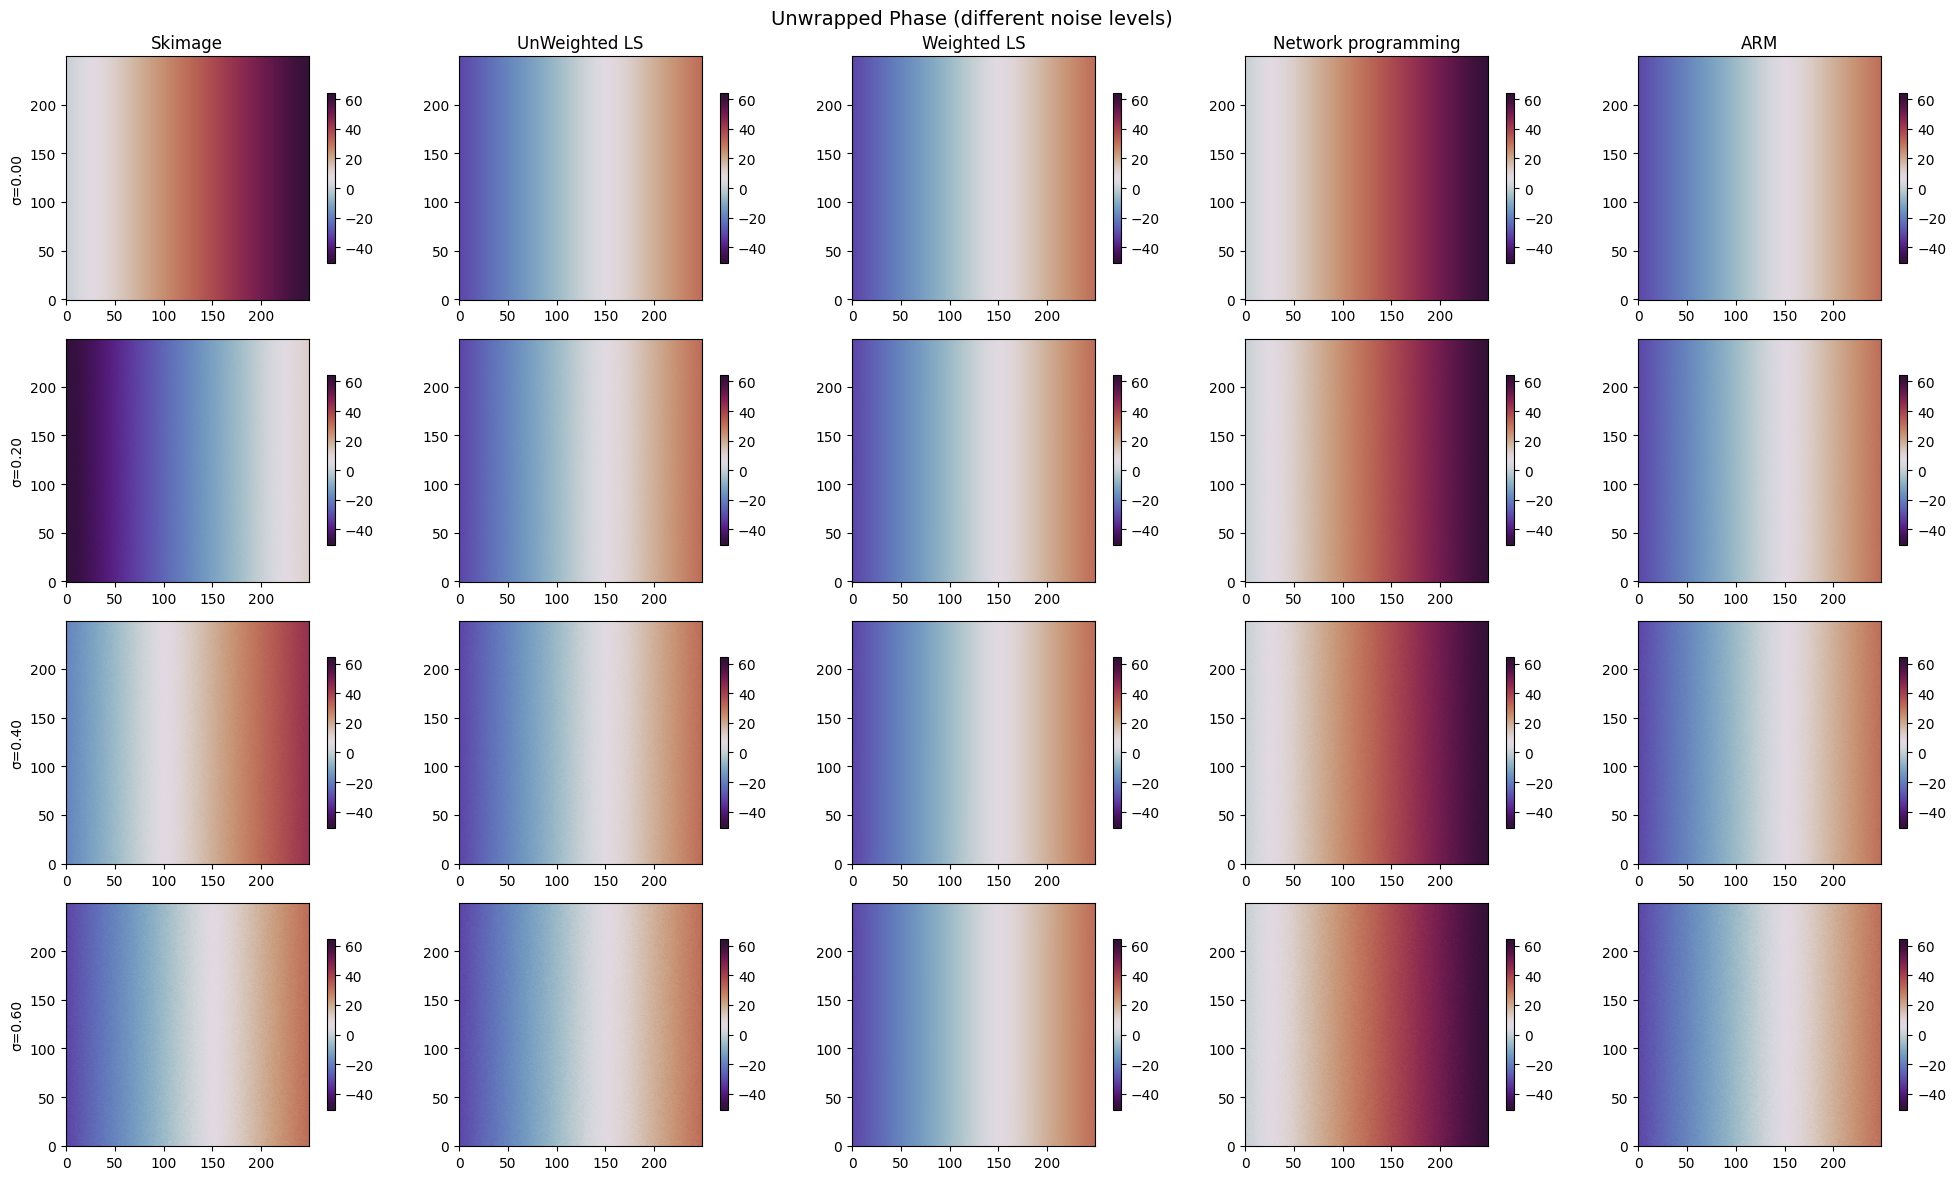

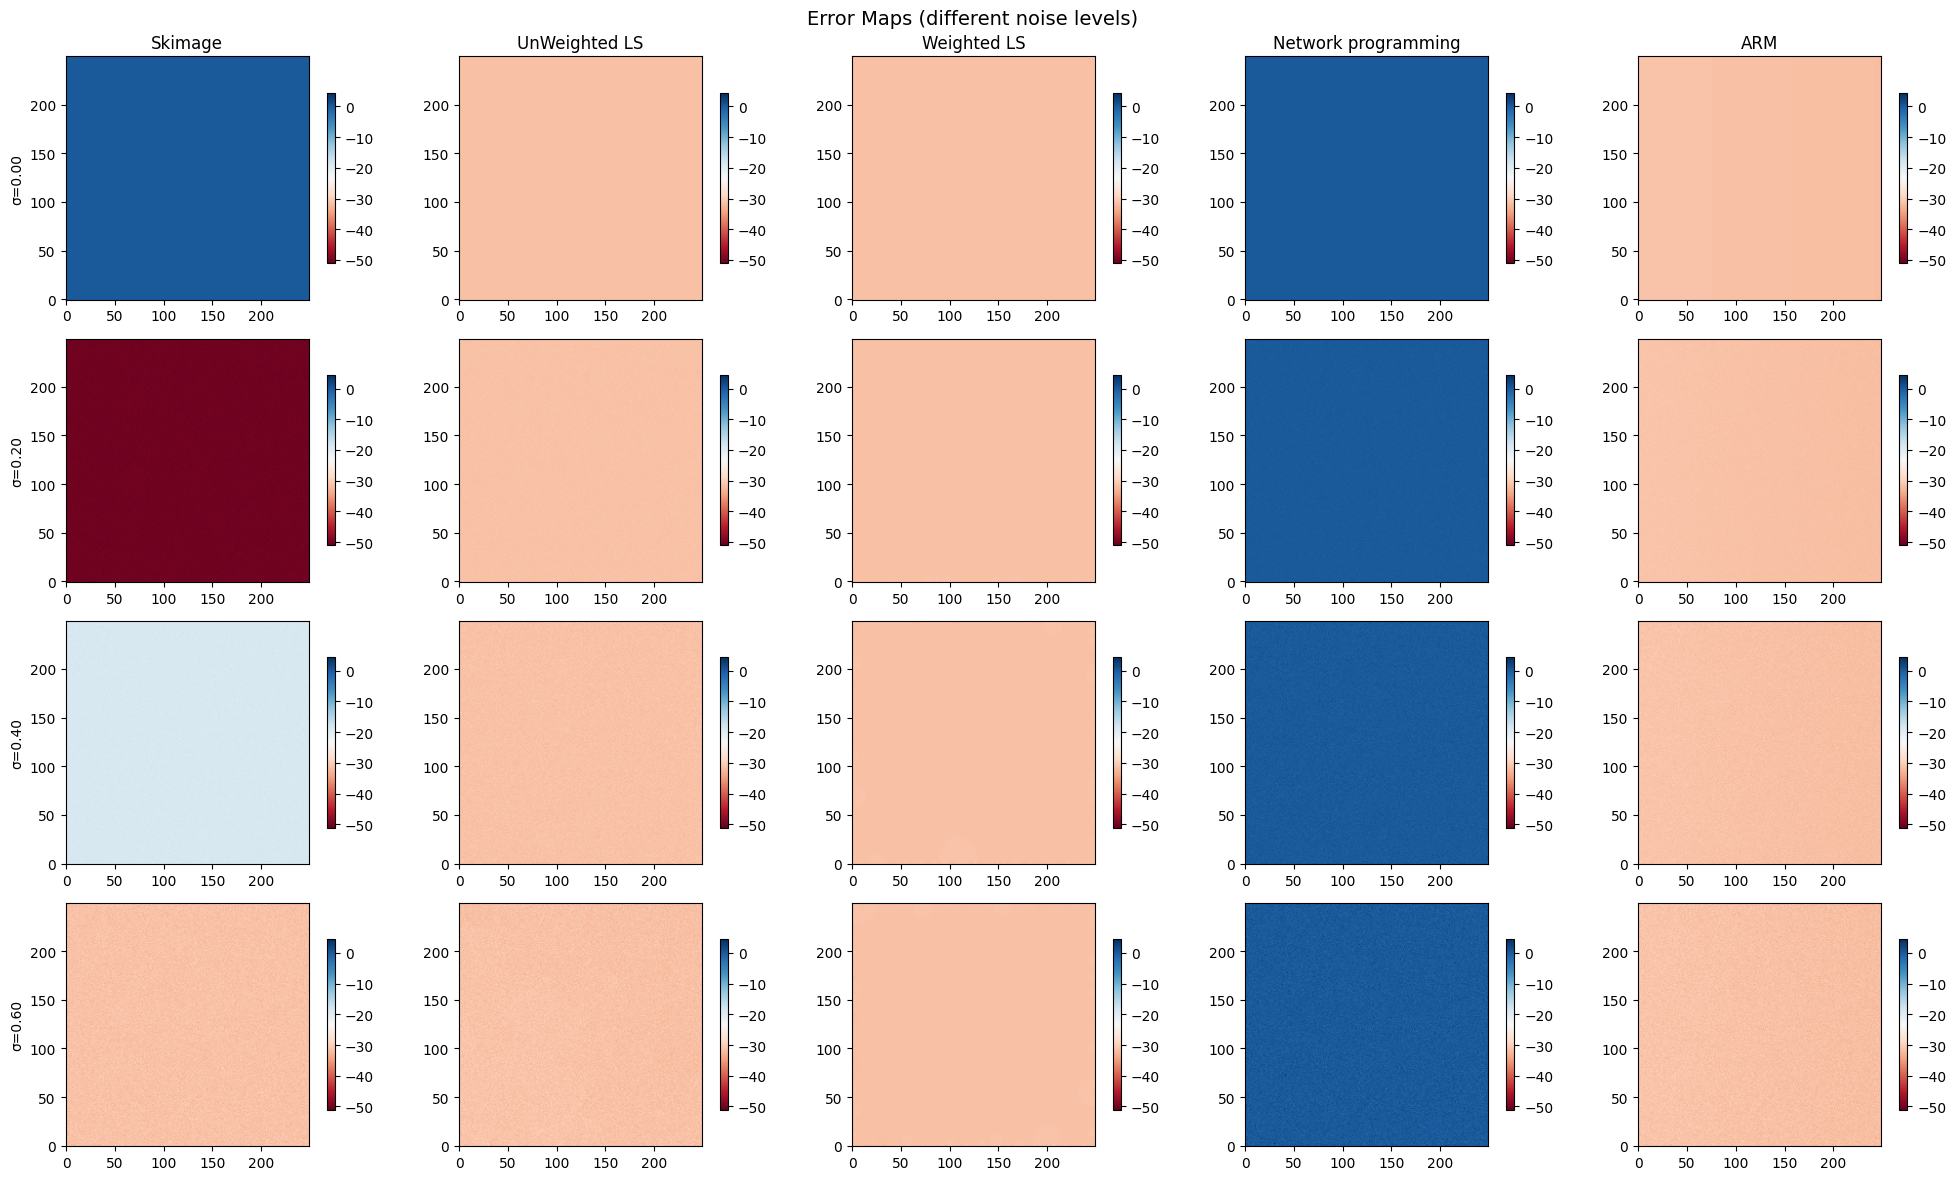

In [4]:
rows, cols = 250, 250                                                           # Image size
x = np.linspace(0, 20*np.pi, cols)                                              # Ramp in x
phi_true_ramp = np.tile(x, (rows, 1))                                           # True phase (ramp)
phi_wrap_ramp = np.angle(np.exp(1j * phi_true_ramp))                            # Wrapped phase
mask = np.ones_like(phi_wrap_ramp, dtype=np.float64)                                 # Mask (over all image) - essential for ARM

tissue_mask = None  # Optional tissue mask (None if not used)

# Noise levels (σ in radians)
""" Loops over different noise levels and unwrap each in each unwrapping method"""

noise_levels = [0 , 0.2, 0.4, 0.6]

all_results = {}

for sigma in noise_levels:
    phi_noisy = additive_noise(phi_wrap_ramp,sigma, enabled= True)

    weights = reliability_weight_map(phi_noisy)
    if tissue_mask is not None:
        weights_masked = weights * tissue_mask
    else: 
        weights_masked = weights 

    results = {
        "Skimage": unwrap_phase(phi_noisy),
        "UnWeighted LS": unwrap_phase_weighted(phi_noisy),
        "Weighted LS": unwrap_phase_weighted(phi_noisy, weights_masked),
        "Network programming": unwrap_dimensional(phi_noisy),
        "ARM": arm_unwrap(phi_noisy, mu=1.0, lam=0.01, iters=100000, omega_init=1)
    }
    all_results[sigma] = (phi_noisy, results)

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(phi_true_ramp, cmap="viridis")
axs[0].set_title("True phase (ramp)")
axs[1].imshow(phi_wrap_ramp, cmap="viridis")
axs[1].set_title("Wrapped phase")
plt.show()


# ------------------------------------------------------------------
# Plot: Unwrapped phases
# ------------------------------------------------------------------
methods = list(next(iter(all_results.values()))[1].keys())
fig, axes = plt.subplots(len(noise_levels), len(methods), figsize=(4*len(methods), 3*len(noise_levels)))

# Use global color scaling across *all* noise levels and methods
all_unwrapped_global = np.concatenate([r.flatten() for sigma, (phi_noisy, res) in all_results.items() for r in res.values()])
vmin_u, vmax_u = np.min(all_unwrapped_global), np.max(all_unwrapped_global)

for row, (sigma, (phi_noisy, results)) in enumerate(all_results.items()):
    for col, (method, phi_u) in enumerate(results.items()):
        ax = axes[row, col] if len(noise_levels) > 1 else axes[col]
        im = ax.imshow(phi_u, cmap="twilight_shifted", origin="lower", vmin=vmin_u, vmax=vmax_u)
        ax.set_aspect('equal')
        if row == 0:
            ax.set_title(method)
        if col == 0:
            ax.set_ylabel(f"σ={sigma:.2f}")
        plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("Unwrapped Phase (different noise levels)", fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Plot: Error maps
# ------------------------------------------------------------------
fig, axes = plt.subplots(len(noise_levels), len(methods), figsize=(4*len(methods), 3*len(noise_levels)))

all_errors_global = np.concatenate([(r - phi_true_ramp).flatten() for sigma, (phi_noisy, res) in all_results.items() for r in res.values()])
vmin_e, vmax_e = np.min(all_errors_global), np.max(all_errors_global)

for row, (sigma, (phi_noisy, results)) in enumerate(all_results.items()):
    for col, (method, phi_u) in enumerate(results.items()):
        ax = axes[row, col] if len(noise_levels) > 1 else axes[col]
        err = phi_u - phi_true_ramp
        im = ax.imshow(err, cmap="RdBu", origin="lower", vmin=vmin_e, vmax=vmax_e)
        ax.set_aspect('equal')
        if row == 0:
            ax.set_title(method)
        if col == 0:
            ax.set_ylabel(f"σ={sigma:.2f}")
        plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("Error Maps (different noise levels)", fontsize=14)
plt.tight_layout()
plt.show()


We will now test how the algorithms deal with discontinuity by introducing a jump between two adjacent ramps

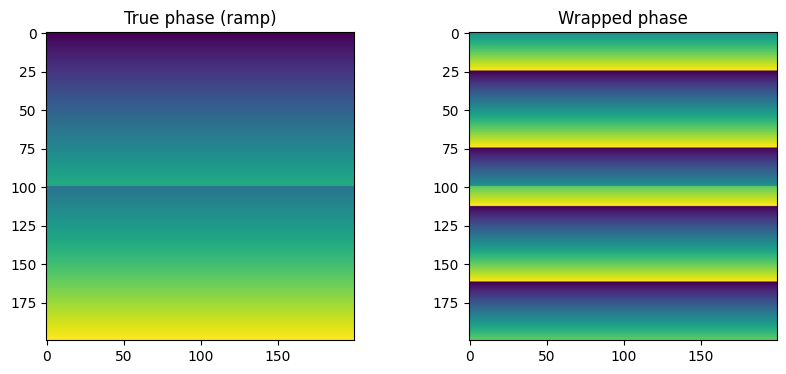

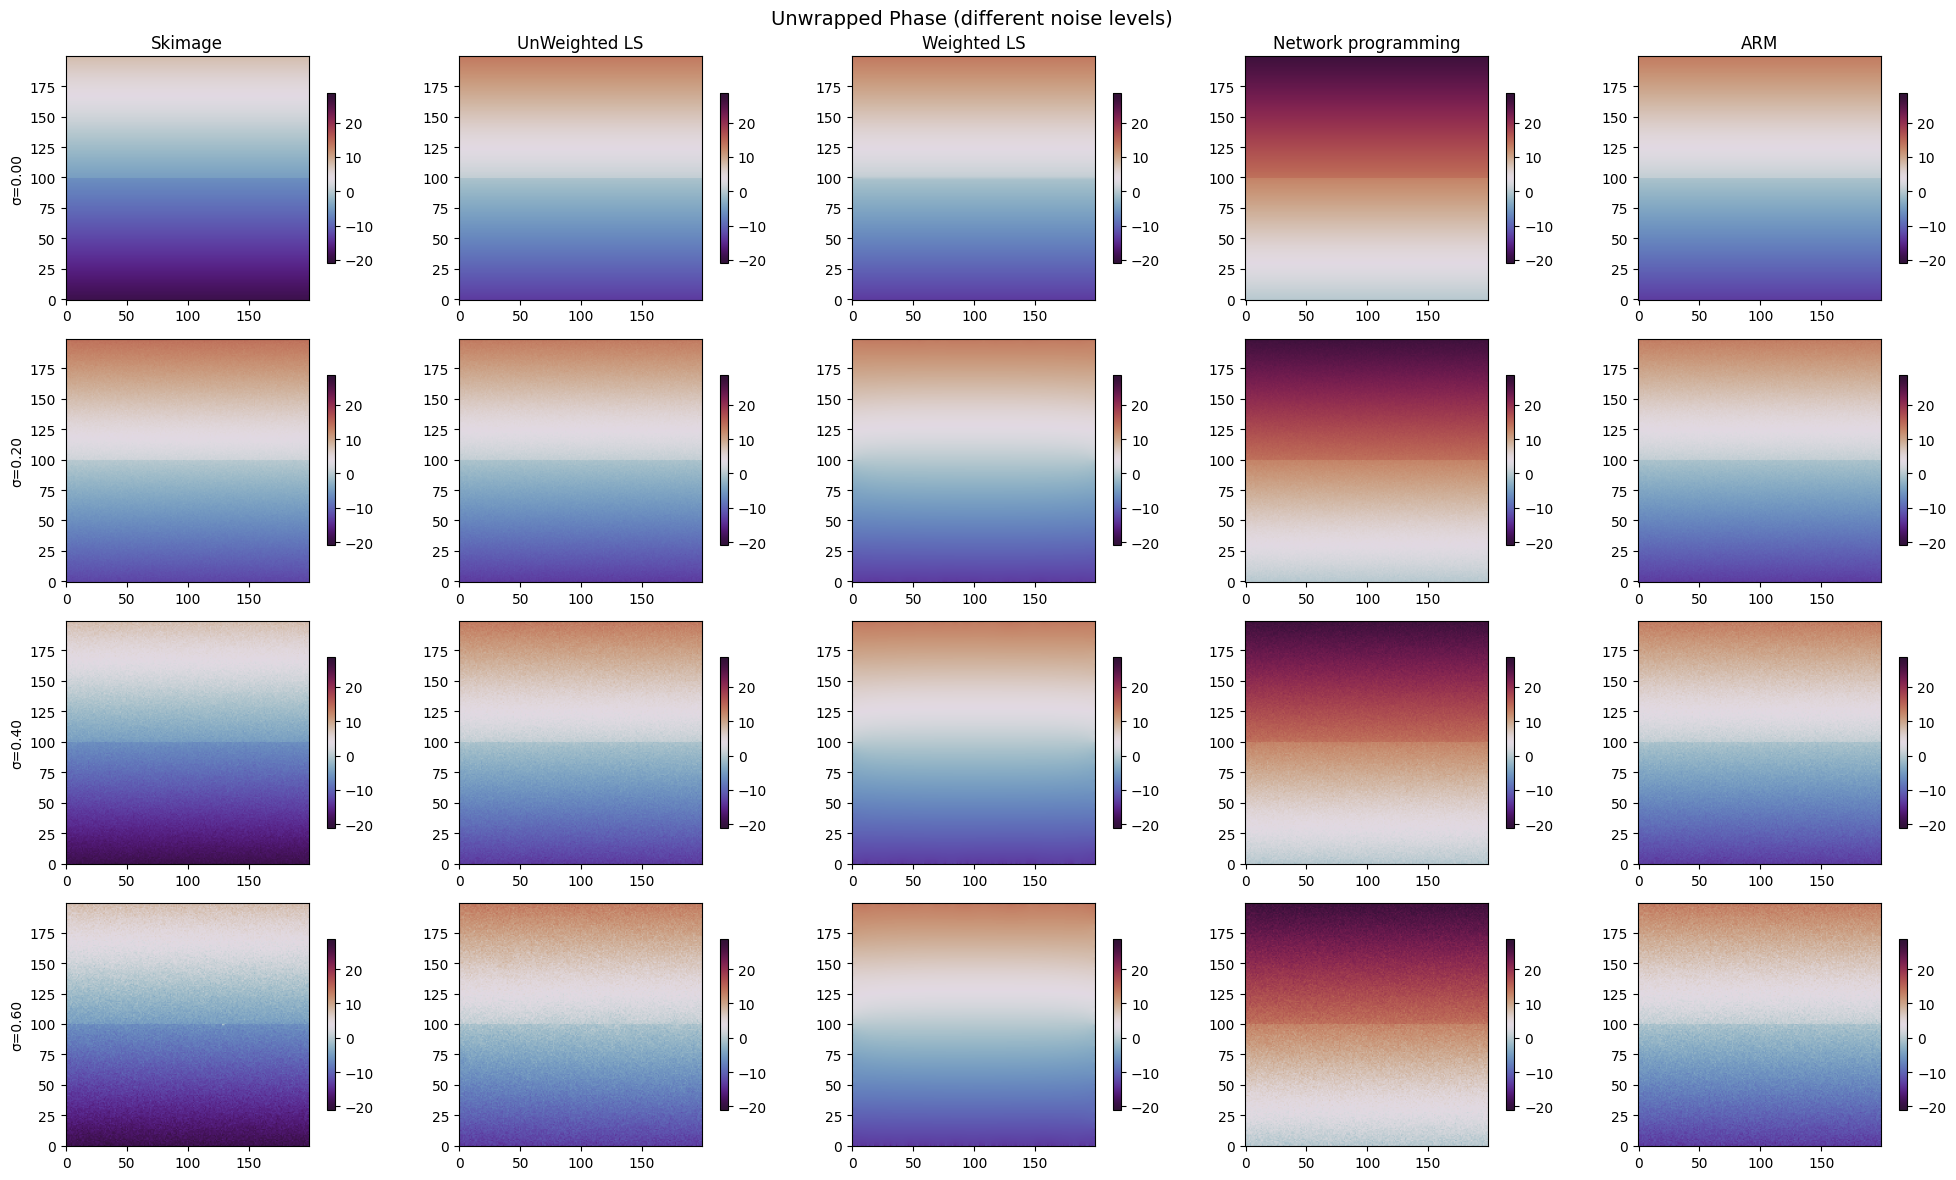

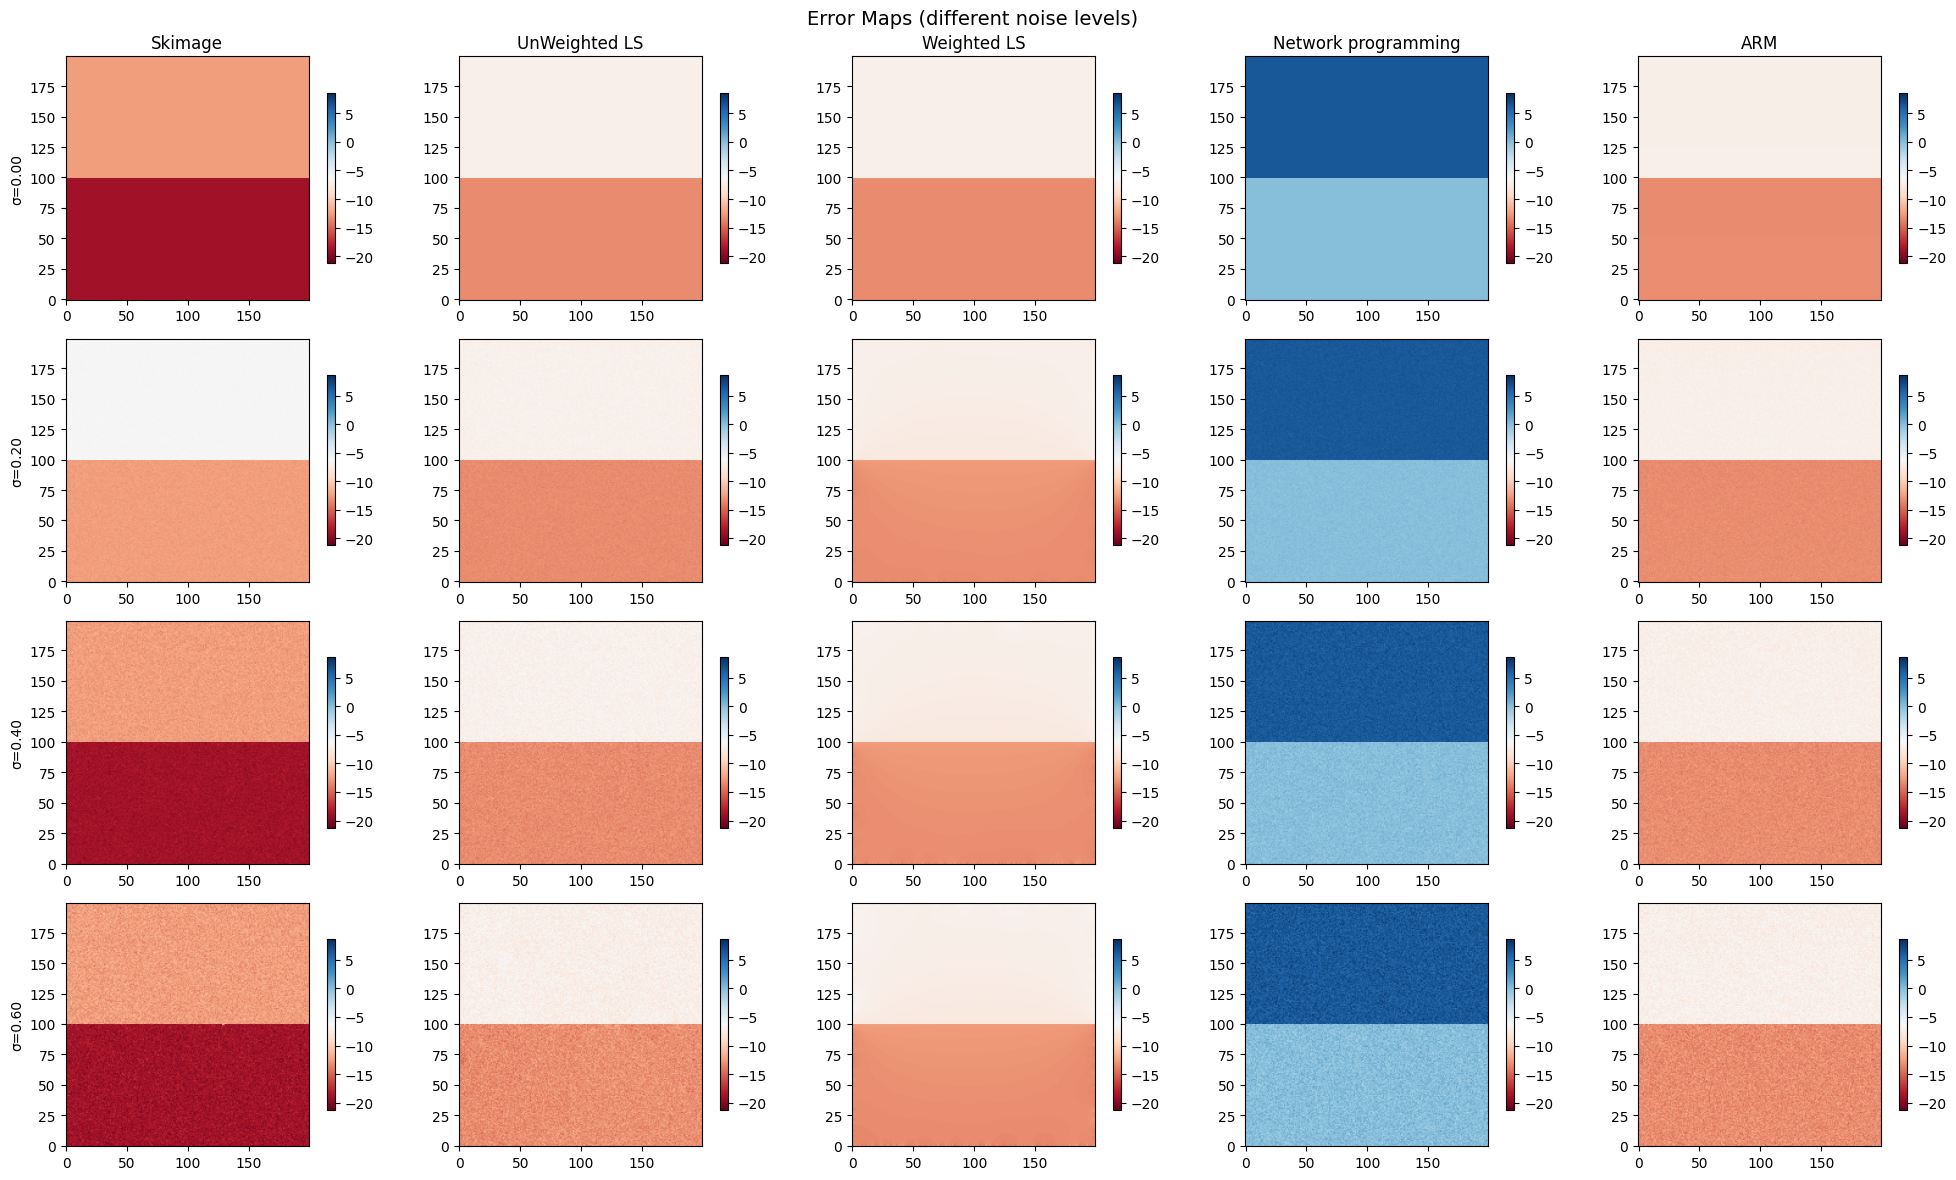

In [6]:
Ny, Nx = 200, 200
step_height = 2.5 * np.pi   # offset between the two ramps

# y axis
y = np.linspace(0, 4*np.pi, Ny//2)  # half the height ramp

# Top half ramp
top_ramp = np.tile(y[:, None], (1, Nx))

# Bottom half ramp, shifted by step_height
bottom_ramp = top_ramp + step_height

# Stack them
phi_true_disc = np.vstack([top_ramp, bottom_ramp])

# Wrap into [-π, π]
phi_wrap_disc = (phi_true_disc + np.pi) % (2*np.pi) - np.pi

tissue_mask = None  # Optional tissue mask (None if not used)

# Noise levels (σ in radians)
""" Loops over different noise levels and unwrap each in each unwrapping method"""

noise_levels = [0 , 0.2, 0.4, 0.6]

all_results = {}

for sigma in noise_levels:
    phi_noisy = additive_noise(phi_wrap_disc,sigma, enabled= True)

    weights = reliability_weight_map(phi_noisy)
    if tissue_mask is not None:
        weights_masked = weights * tissue_mask
    else: 
        weights_masked = weights 

    results = {
        "Skimage": unwrap_phase(phi_noisy),
        "UnWeighted LS": unwrap_phase_weighted(phi_noisy),
        "Weighted LS": unwrap_phase_weighted(phi_noisy, weights_masked),
        "Network programming": unwrap_dimensional(phi_noisy),
        "ARM": arm_unwrap(phi_noisy, mu=1.0, lam=0.01, iters=100000, omega_init=1)
    }
    all_results[sigma] = (phi_noisy, results)

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(phi_true_disc, cmap="viridis")
axs[0].set_title("True phase (ramp)")
axs[1].imshow(phi_wrap_disc, cmap="viridis")
axs[1].set_title("Wrapped phase")
plt.show()


# ------------------------------------------------------------------
# Plot: Unwrapped phases
# ------------------------------------------------------------------
methods = list(next(iter(all_results.values()))[1].keys())
fig, axes = plt.subplots(len(noise_levels), len(methods), figsize=(4*len(methods), 3*len(noise_levels)))

# Use global color scaling across *all* noise levels and methods
all_unwrapped_global = np.concatenate([r.flatten() for sigma, (phi_noisy, res) in all_results.items() for r in res.values()])
vmin_u, vmax_u = np.min(all_unwrapped_global), np.max(all_unwrapped_global)

for row, (sigma, (phi_noisy, results)) in enumerate(all_results.items()):
    for col, (method, phi_u) in enumerate(results.items()):
        ax = axes[row, col] if len(noise_levels) > 1 else axes[col]
        im = ax.imshow(phi_u, cmap="twilight_shifted", origin="lower", vmin=vmin_u, vmax=vmax_u)
        ax.set_aspect('equal')
        if row == 0:
            ax.set_title(method)
        if col == 0:
            ax.set_ylabel(f"σ={sigma:.2f}")
        plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("Unwrapped Phase (different noise levels)", fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Plot: Error maps
# ------------------------------------------------------------------
fig, axes = plt.subplots(len(noise_levels), len(methods), figsize=(4*len(methods), 3*len(noise_levels)))

all_errors_global = np.concatenate([(r - phi_true_disc).flatten() for sigma, (phi_noisy, res) in all_results.items() for r in res.values()])
vmin_e, vmax_e = np.min(all_errors_global), np.max(all_errors_global)

for row, (sigma, (phi_noisy, results)) in enumerate(all_results.items()):
    for col, (method, phi_u) in enumerate(results.items()):
        ax = axes[row, col] if len(noise_levels) > 1 else axes[col]
        err = phi_u - phi_true_disc
        im = ax.imshow(err, cmap="RdBu", origin="lower", vmin=vmin_e, vmax=vmax_e)
        ax.set_aspect('equal')
        if row == 0:
            ax.set_title(method)
        if col == 0:
            ax.set_ylabel(f"σ={sigma:.2f}")
        plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("Error Maps (different noise levels)", fontsize=14)
plt.tight_layout()
plt.show()





We will now test the phase after propagating through a cylinder with constant refractive index

In [7]:
# Grid (µm/px)
Nx, Ny = 512, 512
px, py = 0.2, 0.2

# Material: either a scalar, a 2D array n(x,y), or a callable n_obj(X,Y,z)
n_obj = 1.38      # medium for cylinder
n_med = 1.33      # medium index
pz    = 0.2       # z step for integration (µm)   


R = 20        # radius (µm)
L = 70.0          # axis length along x (µm); set None for infinite

phi_true_cyl, phi_wrap_cyl, tissue_mask, medium_mask  = cylinder_phase_perp_to_z_3d(
    Nx, Ny, px, py,
    R, L,
    lam=lam, n_med=n_med,
    n_obj=n_obj,
    pz=pz
)



In [ ]:
# Noise levels (σ in radians)
""" Loops over different noise levels and unwrap each in each unwrapping method"""

noise_levels = [0 , 0.2, 0.4, 0.6]

all_results = {}

for sigma in noise_levels:
    phi_noisy = additive_noise(phi_wrap_cyl,sigma, enabled= True)

    weights = reliability_weight_map(phi_noisy)
    if tissue_mask is not None:
        weights_masked = weights * tissue_mask
    else: 
        weights_masked = weights 

    results = {
        "Skimage": unwrap_phase(phi_noisy),
        "UnWeighted LS": unwrap_phase_weighted(phi_noisy),
        "Weighted LS": unwrap_phase_weighted(phi_noisy, weights_masked),
        "Network programming": unwrap_dimensional(phi_noisy),
        "ARM": arm_unwrap(phi_noisy, mu=1.0, lam=0.01, iters=100000, omega_init=1)
    }
    all_results[sigma] = (phi_noisy, results)

# ------------------------------------------------------------------
# Plot
# ------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(phi_true_cyl, cmap="viridis")
axs[0].set_title("True phase (Cylinder)")
axs[1].imshow(phi_wrap_cyl, cmap="viridis")
axs[1].set_title("Wrapped phase")
plt.show()


# ------------------------------------------------------------------
# Plot: Unwrapped phases
# ------------------------------------------------------------------
methods = list(next(iter(all_results.values()))[1].keys())
fig, axes = plt.subplots(len(noise_levels), len(methods), figsize=(4*len(methods), 3*len(noise_levels)))

# Use global color scaling across *all* noise levels and methods
all_unwrapped_global = np.concatenate([r.flatten() for sigma, (phi_noisy, res) in all_results.items() for r in res.values()])
vmin_u, vmax_u = np.min(all_unwrapped_global), np.max(all_unwrapped_global)

for row, (sigma, (phi_noisy, results)) in enumerate(all_results.items()):
    for col, (method, phi_u) in enumerate(results.items()):
        ax = axes[row, col] if len(noise_levels) > 1 else axes[col]
        im = ax.imshow(phi_u, cmap="twilight_shifted", origin="lower", vmin=vmin_u, vmax=vmax_u)
        ax.set_aspect('equal')
        if row == 0:
            ax.set_title(method)
        if col == 0:
            ax.set_ylabel(f"σ={sigma:.2f}")
        plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("Unwrapped Phase (different noise levels)", fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Plot: Error maps
# ------------------------------------------------------------------
fig, axes = plt.subplots(len(noise_levels), len(methods), figsize=(4*len(methods), 3*len(noise_levels)))

all_errors_global = np.concatenate([(r - phi_true_cyl).flatten() for sigma, (phi_noisy, res) in all_results.items() for r in res.values()])
vmin_e, vmax_e = np.min(all_errors_global), np.max(all_errors_global)

for row, (sigma, (phi_noisy, results)) in enumerate(all_results.items()):
    for col, (method, phi_u) in enumerate(results.items()):
        ax = axes[row, col] if len(noise_levels) > 1 else axes[col]
        err = phi_u - phi_true_cyl
        im = ax.imshow(err, cmap="RdBu", origin="lower", vmin=vmin_e, vmax=vmax_e)
        ax.set_aspect('equal')
        if row == 0:
            ax.set_title(method)
        if col == 0:
            ax.set_ylabel(f"σ={sigma:.2f}")
        plt.colorbar(im, ax=ax, shrink=0.7)

plt.suptitle("Error Maps (different noise levels)", fontsize=14)
plt.tight_layout()
plt.show()





Evaluation of NRMSE vs noise level for each methos

In [ ]:
noise_levels = [0.0, 0.2, 0.4, 0.6]   # radians
n_runs = 10

rmse_results = {sigma: {m: [] for m in ["SciPy", "UnWeighted LS", "Weighted LS", "Kamui"]}
                for sigma in noise_levels}

for sigma in noise_levels:
    for run in range(n_runs):
        # Add noise to wrapped phase
        phi_noisy = additive_noise(phi_wrapped, sigma, enabled=True)

        # Compute weights
        weights        = reliability_weight_map(phi_noisy)
        weights_masked = weights * tissue_mask
        weights_masked = weights_masked / (weights_masked.max() + 1e-8)
        weights_masked = np.clip(weights_masked, 0.05, 1.0)

        # Unwrap
        phi_skimage   = unwrap_phase(phi_noisy)
        phi_ls        = unwrap_phase_weighted(phi_noisy)
        phi_weight    = unwrap_phase_weighted(phi_noisy, weights_masked)
        phi_np        = unwrap_dimensional(phi_noisy)

        # RMSE evaluation
        rmse_results[sigma]["Skimage"].append(evaluate_phase(phi_true, phi_scipy, tissue_mask))
        rmse_results[sigma]["UnWeighted LS"].append(evaluate_phase(phi_true, phi_ls, tissue_mask))
        rmse_results[sigma]["Weighted LS"].append(evaluate_phase(phi_true, phi_weight, tissue_mask))
        rmse_results[sigma]["Network programming"].append(evaluate_phase(phi_true, phi_kamui, tissue_mask))

# ------------------------------------------------------
# Report
# ------------------------------------------------------
print("Mean RMSE per method (10 runs each):")
for sigma in noise_levels:
    print(f"\nNoise σ = {sigma}")
    for method, vals in rmse_results[sigma].items():
        mean_rmse = np.mean(vals)
        std_rmse  = np.std(vals)
        print(f"  {method:15s}: {mean_rmse:.4f} ± {std_rmse:.4f} rad")